In [1]:
import numpy as np
import scipy as sp
import perfplot

In [2]:
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# local imports
from src.msh.mesh import Mesh2D
import src.msh.util as mshu
import src.pyutil as pyutil

# `fix` 

MPU calls a `fix` function which is supposed to fix a faulty connectivity matrix and remove duplicate nodes.

__Why it needs to reworked__:
- It's unclear to me why there is a danger of passing a faulty `T, P` array, or why it is this code's job to fix a bad mesh. 
- `fix` calls the handwritten functions `unique`, `sortrows`, which are potentially unstable reinventions of existing `numpy` library functions, and therefore the "fixing" of the mesh becomes to expensive for large meshes.
- fix re-orders the elements, which is important for MPI runs; we shold make sure that it's happening in a sensible way

It may or may not return the connectivity in counter clockwise order -- this is not mentioned in the function documentation. Let's go through it and figure out what is happening and re-write it in a more sane way. EDIT: Yes, it does this, but that isn't mentioned in the documentation.

## `util.unique`

MPU function which finds and returns unique elements, rows, or columns in a 2D numpy array. Except, the `np.unique` function provides an optional keyword argument which specifies the axis to return by -- `np.unique(arr, axis=0)` sorts rows and `np.unique(arr, axis=1)` sorts columns...

```Python
    # Eliminate duplicate elements
    # CM: This will sort the elements by increasing first node number
    t = util.unique(t, 'rows')
```

but is it __really__ that slow? Let's check.

100%|██████████| 3/3 [00:10<00:00,  3.56s/it]


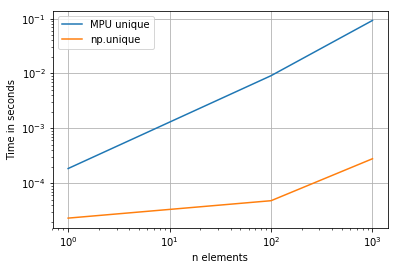

In [5]:
out = perfplot.bench(
    setup=lambda n: np.random.randint(n, size=(n, 4)),
    kernels=[
        lambda a: pyutil.unique(a, 'rows'),
        lambda a: np.unique(a, axis=0)
    ],
    labels=['MPU unique', 'np.unique'],
    n_range=[1, 100, 1000],
    xlabel='n elements',
    logx=True,
    logy=True
);
out.show()

Yikes, 2 orders of magnitude slower for meshes of 1000 elements. Ok, so let's cut out calls to that.

# element connectivities

# Mesh test cases

mesh with CW elements

In [6]:
# new mesh, mixed rose mesh
rP = np.array(
      [[ -2.,    2.,  0. ],
       [  0.,    8.,  0. ],
       [  2.,    2.,  0. ],
       [  3.,    0.,  0. ],
       [  2.,   -2.,  0. ],
       [  0.,   -8.,  0. ],
       [ -2.,   -2.,  0. ],
       [ -3.,    0.,  0. ]])

rT = np.array(
      [[0, 2, 1, -1],
       [0, 4, 2,  6],
       [2, 3, 4, -1],
       [4, 6, 5, -1],
       [0, 6, 7, -1]])

# create the mesh based on the custon con, pts above
_rose_mesh = Mesh2D(rT, rP)

In [7]:
# bug in the triangle
correct_T = np.array(
      [[0, 1, 2, -1],
       [2, 3, 4, -1],
       [4, 5, 6, -1],
       [0, 6, 7, -1],
       [0, 2, 4,  6]])

_rose_mesh.elm

array([[ 0,  2,  1, -1],
       [ 3,  2,  4, -1],
       [ 4,  6,  5, -1],
       [ 6,  0,  7, -1],
       [ 2,  0,  6,  4]])

In [8]:
def get_nonneg(arr): return arr[arr >= 0]

def draw_annotated_elm(ax, T, P, elm):
    elmT = get_nonneg(T[elm, :])
    pts = P[elmT, :-1]
    ax.scatter(pts[:,0], pts[:,1])
    for idx, pt in enumerate(pts):
        ax.annotate('{}'.format(idx), xy=pt)
    return ax

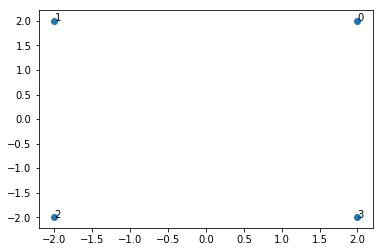

In [9]:
washed_T = _rose_mesh.elm
washed_P = _rose_mesh.vert

fig, ax = plt.subplots()
draw_annotated_elm(ax, washed_T, washed_P, 4)

In [10]:
_rose_mesh.vol()

array([12.,  2., 12.,  2., 16.])